# Attempt with Fraudolent classifier + Case Classifier

In [1]:
import time
import numpy as np
import pandas as pd
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import mean_squared_error, accuracy_score, plot_confusion_matrix, f1_score
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix

import stellargraph as sg
from stellargraph import datasets
from stellargraph.mapper import (
    CorruptedGenerator,
    FullBatchNodeGenerator,
    GraphSAGENodeGenerator,
    HinSAGENodeGenerator,
    Node2VecNodeGenerator,
    ClusterNodeGenerator,
)
from stellargraph.layer import GCN, DeepGraphInfomax, GraphSAGE, GAT, APPNP, HinSAGE, Dense

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Model, optimizers, losses, metrics

from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN, BorderlineSMOTE, KMeansSMOTE, SMOTENC, SVMSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.metrics import classification_report_imbalanced

from collections import Counter, defaultdict
import multiprocessing
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [2]:
import sys
sys.path.append('../')
import utils

In [3]:
v_data, e_data, v_sets, e_sets, core_targets, ext_targets, core_testing = utils.load_for_jupyter()

Dataset already downloaded. Loading it from file system
LOADING DATA: 1.09 s
PREPROCESSING: 1.10 s


In [4]:
# Sort based on testingFlag
for i in v_sets:
    v_sets[i] = v_sets[i].sort_values('testingFlag')
    print(i,":")
    print(v_sets[i].testingFlag.value_counts())
    v_sets[i] = v_sets[i].drop('testingFlag', axis=1)

Account :
-1.0    126863
 0.0     13769
 1.0      1244
Name: testingFlag, dtype: int64
Address :
-1.0    28432
 0.0     1568
Name: testingFlag, dtype: int64
Customer :
-1.0    42127
 0.0    13650
 1.0      449
Name: testingFlag, dtype: int64
Derived Entity :
-1.0    27286
 0.0     3925
 1.0       63
Name: testingFlag, dtype: int64
External Entity :
-1.0    55207
 0.0     4757
 1.0       36
Name: testingFlag, dtype: int64


In [5]:
for i in v_sets:
    v_sets[i] = v_sets[i].drop('ExtendedCaseGraphID', axis=1)

In [6]:
# DGI parameters
batch_size = 200
epochs = 15
num_samples = [8, 4]
dropout = 0.4
hinsage_layer_sizes = [32, 32]

In [7]:
G = sg.StellarDiGraph(v_sets, e_sets)

# Step 1: HinSAGE DGI (for unsupervised embeddings)

In [8]:
generator = HinSAGENodeGenerator(
    G, 
    batch_size, 
    num_samples,
    head_node_type="Account"
)

def make_hinsage():
    return HinSAGE(
    layer_sizes=hinsage_layer_sizes,
    activations=['relu', 'relu'],
    generator=generator, 
    bias=True,
    normalize="l2",
    dropout=dropout
)

hinsage = make_hinsage()

In [9]:
def run_deep_graph_infomax(base_model, generator, epochs):
    t0 = time.time()
    corrupted_generator = CorruptedGenerator(generator)
    gen = corrupted_generator.flow(G.nodes(node_type="Account"))
    infomax = DeepGraphInfomax(base_model, corrupted_generator)

    x_in, x_out = infomax.in_out_tensors()

    # Train DGI
    model = Model(inputs=x_in, outputs=x_out)
    model.compile(loss=tf.nn.sigmoid_cross_entropy_with_logits, optimizer=Adam(lr=1e-3))
    es = EarlyStopping(monitor="loss", min_delta=0, patience=15)
    history = model.fit(gen, epochs=epochs, verbose=1, callbacks=[es])
    sg.utils.plot_history(history)

    x_emb_in, x_emb_out = base_model.in_out_tensors()
    if generator.num_batch_dims() == 2:
        x_emb_out = tf.squeeze(x_emb_out, axis=0)

    t1 = time.time()
    print(f'Time required: {t1-t0:.2f} s ({(t1-t0)/60:.1f} min)')
    
    return x_emb_in, x_emb_out, model

Epoch 1/15
710/710 [==============================] - 76s 108ms/step - loss: 0.43411s
Epoch 2/15
710/710 [==============================] - 76s 108ms/step - loss: 0.33479s - - ET - ETA: 3s - loss: 0.33 - ETA - ETA: 1s - l
Epoch 3/15
710/710 [==============================] - 77s 109ms/step - loss: 0.2782
Epoch 4/15
710/710 [==============================] - 77s 109ms/step - loss: 0.222010s - los - ETA - ETA: 4s - lo - ETA: 3s - - 
Epoch 5/15
710/710 [==============================] - 75s 106ms/step - loss: 0.1795
Epoch 6/15
710/710 [==============================] - 76s 106ms/step - loss: 0.158110s - ETA: 8s - l - ETA - ETA: 0s - loss: 0.1
Epoch 7/15
710/710 [==============================] - 72s 102ms/step - loss: 0.14225s - loss: 0 - ETA: 4  - ETA: 0s - los
Epoch 8/15
710/710 [==============================] - 79s 112ms/step - loss: 0.12570s - loss: 0
Epoch 9/15
710/710 [==============================] - 79s 111ms/step - loss: 0.11120s - loss:
Epoch 10/15
710/710 [===================

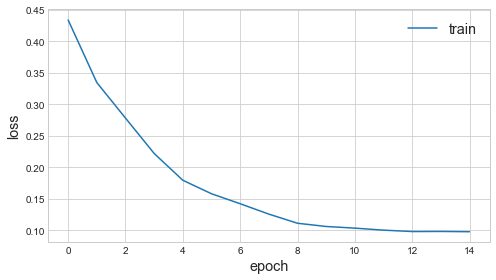

In [10]:
x_in, x_out, model = run_deep_graph_infomax(hinsage, generator, epochs)

In [12]:
# locate the training and CV datasets based on the testingFlag value.

train_cv_set = v_sets['Account'][126863:126863+13769]
node_ids = train_cv_set.index.values.tolist()

In [13]:
emb_model = Model(inputs=x_in, outputs=x_out)

train_cv_embs = emb_model.predict(
    generator.flow(node_ids)
)

# Step 2: Fraudolent flag classifier using embeddings as input

In [106]:
# Take the training_cv set and find its 'fraudolent' flag labels
# This data is all relative to account type nodes.

v_data.ExtendedCaseGraphID = v_data.ExtendedCaseGraphID.fillna(0)
v_data['Fraudolent'] = np.where(v_data.ExtendedCaseGraphID != 0, 1, 0)

ext_id_labels = v_data.loc[[int(node_id) for node_id in node_ids]].ExtendedCaseGraphID
fraud_labels = v_data.loc[[int(node_id) for node_id in node_ids]].Fraudolent

# TRAIN
train_set = train_cv_embs[:10000]
train_labels = fraud_labels.values[:10000]
train_ext_labels = ext_id_labels.values[:10000]

# CV
cv_set = train_cv_embs[-3769:]
cv_labels = fraud_labels.values[-3769:]
cv_ext_labels = ext_id_labels.values[-3769:]

# TEST
#test_set = v_sets['Account'][-1244:]

In [48]:
# Experiment different classifiers:
classifiers = {
    'mnb': MultinomialNB(),
    'gnb': GaussianNB(),
    'svm1': SVC(kernel='linear'),
    'svm2': SVC(kernel='rbf'),
    'svm3': SVC(kernel='sigmoid'),
    'mlp1': MLPClassifier(max_iter=500),
    'mlp2': MLPClassifier(hidden_layer_sizes=[100, 100], max_iter=500),
    'ada': AdaBoostClassifier(),
    'dtc': DecisionTreeClassifier(),
    'rfc': RandomForestClassifier(),
    'gbc': GradientBoostingClassifier(),
    'lr': LogisticRegression(multi_class="auto", solver="lbfgs", max_iter=200)
}

f1_scores = dict()
accs = dict()
def test_classifiers():
    for clf_name in classifiers:
        t0 = time.time()
        clf = classifiers[clf_name]
        clf.fit(train_set, train_labels)
        cv_pred = clf.predict(cv_set)
        clf_f1 = f1_score(cv_labels, cv_pred, average='weighted')
        clf_acc = (cv_pred == cv_labels).mean()
        f1_scores[clf_name] = clf_f1
        accs[clf_name] = clf_acc
        t1 = time.time()
        print(f"Classifier: {clf_name} - f1: {clf_f1:.3f} - acc: {clf_acc:.3f} - time: {t1-t0:.0f} s")
        
test_classifiers()

Classifier: mnb - f1: 0.726 - acc: 0.781 - time: 0 s
Classifier: gnb - f1: 0.836 - acc: 0.846 - time: 0 s
Classifier: svm1 - f1: 0.934 - acc: 0.932 - time: 1 s
Classifier: svm2 - f1: 0.936 - acc: 0.935 - time: 2 s
Classifier: svm3 - f1: 0.823 - acc: 0.822 - time: 2 s
Classifier: mlp1 - f1: 0.945 - acc: 0.944 - time: 8 s
Classifier: mlp2 - f1: 0.943 - acc: 0.941 - time: 15 s
Classifier: ada - f1: 0.946 - acc: 0.944 - time: 1 s
Classifier: dtc - f1: 0.912 - acc: 0.912 - time: 0 s
Classifier: rfc - f1: 0.947 - acc: 0.945 - time: 1 s
Classifier: gbc - f1: 0.946 - acc: 0.945 - time: 2 s
Classifier: lr - f1: 0.916 - acc: 0.916 - time: 0 s


In [49]:
# Looks like the GradientBoostingClassifier performs well in a short time,
# but also a RandomTree and others work well.

classifier = GradientBoostingClassifier()

In [50]:
classifier.fit(
    X=train_set,
    y=train_labels,
)

GradientBoostingClassifier()

In [51]:
cv_pred = classifier.predict(cv_set)
f1_avg = f1_score(cv_labels, cv_pred, average='weighted')
acc = (cv_pred == cv_labels).mean()

print(f"f1: {f1_avg:.3f} - acc: {acc:.3f}")

f1: 0.946 - acc: 0.945


# Step 3: Take the fraudolent nodes embeddings

In [158]:
# must take the cv_pred=1 out of the cv_set
# in final version this is going to be with test_set and test_pred

fraud_embs_dirty = dict()
for i in range(len(cv_pred)):
    fraud_embs_dirty[i] = cv_set[i] if cv_pred[i] != 0 else None

fraud_embs = dict()
l = 0

for key, value in fraud_embs_dirty.items():
    if value is not None:
        fraud_embs[l] = value
    l += 1

fraud_embs = pd.DataFrame.from_dict(fraud_embs, orient='index')
fraud_embs = fraud_embs.to_numpy()

In [156]:
# Then take the labels of cv_labels ordered like the newly created fraud_embs

cv_fraud_labels = [cv_ext_labels[i] if cv_labels[i] == 1 else -10 for i in range(len(cv_labels))]
cv_fraud_labels = [i for i in cv_fraud_labels if i != -10]

In [ ]:
# Then I can train a second classifier.
# First, I oversample the classes directly on the embeddings
# then I train a classifier on the fraudolent train set and fraudolent cv set

In [177]:
train_cv_set.index.values

array([15020041132, 15020041134, 15020058888, ..., 15020056211,
       15020055820, 15020086327])

In [185]:
# Here are the node_id's of the train_cv embedded vectors

embs_df = pd.DataFrame(train_cv_embs)
embs_df['node_id'] = train_cv_set.index.values
embs_df = embs_df.set_index('node_id')

# Here are the node_id's of the train and cv sets of embeddings separately

train_embs_df = embs_df.iloc[:10000]
cv_embs_df = embs_df.iloc[-3769:]

# Adding Fraudolent flag to embeddings with node_id's

embs_df['Fraudolent'] = fraud_labels

# Adding HasCoreID flag to check if the node already has a coreID. If it does, 
# I don't use it for case classification.

embs_df['HasCoreID'] = np.where(train_cv_set.CoreCaseGraphID != 0, 1, 0)

In [194]:
embs_df

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,Fraudolent,HasCoreID
node_id,,,,,,,,,,,,,,,,,,,,,
15020041132,0.0,0.0,0.076221,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.230978,0.000000,0.298860,0.523285,0.0,0.000000,0.371585,0.089063,1,0
15020041134,0.0,0.0,0.003330,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.487108,0.000000,0.0,0.000000,0.000000,0.483870,1,0
15020058888,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.445788,1,0
15020021707,0.0,0.0,0.209408,0.0,0.0,0.233378,0.0,0.0,0.000000,0.024445,...,0.000000,0.000000,0.399712,0.000000,0.0,0.000000,0.000000,0.656971,1,1
15020022245,0.0,0.0,0.000000,0.0,0.0,0.277297,0.0,0.0,0.065981,0.000000,...,0.000000,0.007793,0.000000,0.000000,0.0,0.000000,0.000000,0.370098,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15020082878,0.0,0.0,0.233272,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.070546,0.773966,0.184569,0.000000,0.0,0.000000,0.000000,0.320450,1,0
15020028999,0.0,0.0,0.025087,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.419877,0.000000,0.0,0.000000,0.000000,0.589483,1,0
15020056211,0.0,0.0,0.000000,0.0,0.0,0.276370,0.0,0.0,0.092483,0.000000,...,0.000000,0.000000,0.000000,0.094322,0.0,0.126972,0.000000,0.269577,0,1


In [196]:
# Use as train_cv_set_classify all the nodes that have fraudolent = 1 and hasCoreID = 0
# Note that this way I'm using the previous CV set size (3769) as both the train + CV size of the new classifier.

# It should be smart to use way less nodes for the fraudolent classification, since it already has 95% acc.
# Currently is training = 10'000 and cv = 3769 nodes. (for Account only)
# This task instead requires all the data available.

train_cv_set_classify = embs_df.loc[embs_df['Fraudolent'] == 1]
train_cv_set_classify = train_cv_set_classify.loc[train_cv_set_classify['HasCoreID'] == 0]

In [202]:
train_cv_set_classify

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,Fraudolent,HasCoreID
node_id,,,,,,,,,,,,,,,,,,,,,
15020041132,0.0,0.000000,0.076221,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.230978,0.000000,0.298860,0.523285,0.0,0.0,0.371585,0.089063,1,0
15020041134,0.0,0.000000,0.003330,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.487108,0.000000,0.0,0.0,0.000000,0.483870,1,0
15020058888,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.445788,1,0
15020083260,0.0,0.029164,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.410915,0.000000,0.0,0.0,0.000000,0.481257,1,0
15020013829,0.0,0.000000,0.089667,0.0,0.0,0.0,0.0,0.0,0.053135,0.0,...,0.000000,0.000000,0.065229,0.000000,0.0,0.0,0.000000,0.435312,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15020082717,0.0,0.000000,0.100224,0.0,0.0,0.0,0.0,0.0,0.069534,0.0,...,0.000000,0.000000,0.004748,0.029822,0.0,0.0,0.000000,0.321469,1,0
15020082878,0.0,0.000000,0.233272,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.070546,0.773966,0.184569,0.000000,0.0,0.0,0.000000,0.320450,1,0
15020028999,0.0,0.000000,0.025087,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.419877,0.000000,0.0,0.0,0.000000,0.589483,1,0


In [204]:
# I have taken 100% of the correct fraudolent nodes. In reality, this is going to be lower since in the 
# test_set I'm going to rely on the predictions from the first classifier to decide which nodes to include 
# in the second one.

# I don't need a first classifier if all the data from train and cv sets are labeled. 
# This means that when I have test_set data, 1, I predict the embeddings, then 
# 2. I predict the fraudolent nodes, then 3. I predict the Extended Case.
# But for training and CV purposes, I don't need to take only the predicted Fraudolent nodes.

In [205]:
# This technique assumes that the test and cv set are extracted from the same distribution. 
# If this is not the case, this model is not able to predict a case it has never seen before.

In [207]:
train_cv_set_classify = train_cv_set_classify.drop(['Fraudolent', 'HasCoreID'], axis=1)
train_cv_set_classify_np = train_cv_set_classify.to_numpy()

In [209]:
train_cv_set_classify_np.shape

(9287, 32)

In [210]:
# Split for the classifier: about 75%, 25% (only 9287 samples)
# train size: 7000 - CV size: 2287

node_ids = train_cv_set_classify.index.values.tolist()
ext_id_labels = v_data.loc[[int(node_id) for node_id in node_ids]].ExtendedCaseGraphID

# TRAIN
train_set = train_cv_set_classify[:7000]
train_ext_labels = ext_id_labels.values[:7000]

# CV
cv_set = train_cv_embs[-2287:]
cv_ext_labels = ext_id_labels.values[-2287:]

In [212]:
ext_id_labels.value_counts().to_frame()

,ExtendedCaseGraphID
3794.0,31
120.0,30
333.0,30
1027.0,29
3248.0,29
...,...
899.0,1
3290.0,1
2934.0,1
2869.0,1


In [224]:
# Experiment different classifiers: WITHOUT SUPERSAMPLING::
classifiers = {
    'mnb': MultinomialNB(),
    'gnb': GaussianNB(),
    'svm1': SVC(kernel='linear'),
    'svm2': SVC(kernel='rbf'),
    'svm3': SVC(kernel='sigmoid'),
    #'mlp1': MLPClassifier(max_iter=500),
    #'mlp2': MLPClassifier(hidden_layer_sizes=[100, 100], max_iter=500),
    'ada': AdaBoostClassifier(),
    'dtc': DecisionTreeClassifier(),
    'rfc': RandomForestClassifier(),
    #'gbc': GradientBoostingClassifier(),
    'lr': LogisticRegression(multi_class="auto", solver="lbfgs", max_iter=200)
}

f1_scores = dict()
accs = dict()
def test_classifiers():
    for clf_name in classifiers:
        t0 = time.time()
        clf = classifiers[clf_name]
        clf.fit(train_set, train_ext_labels)
        cv_pred = clf.predict(cv_set)
        clf_f1 = f1_score(cv_ext_labels, cv_pred, average='weighted')
        clf_acc = (cv_pred == cv_ext_labels).mean()
        f1_scores[clf_name] = clf_f1
        accs[clf_name] = clf_acc
        t1 = time.time()
        print(f"Classifier: {clf_name} - f1: {clf_f1:.3f} - acc: {clf_acc:.3f} - time: {t1-t0:.0f} s")
        
test_classifiers()

Classifier: mnb - f1: 0.000 - acc: 0.003 - time: 0 s
Classifier: gnb - f1: 0.000 - acc: 0.000 - time: 1 s
Classifier: svm1 - f1: 0.000 - acc: 0.003 - time: 137 s
Classifier: svm2 - f1: 0.000 - acc: 0.003 - time: 139 s
Classifier: svm3 - f1: 0.000 - acc: 0.003 - time: 139 s
Classifier: ada - f1: 0.000 - acc: 0.003 - time: 24 s
Classifier: dtc - f1: 0.001 - acc: 0.001 - time: 4 s
Classifier: rfc - f1: 0.001 - acc: 0.001 - time: 91 s
Classifier: lr - f1: 0.000 - acc: 0.002 - time: 22 s


# Introduce supersampling

The class imbalance is not SUPER bad like before. Now it's close to 30:1 at worst.

In [228]:
rs = RandomOverSampler(random_state=3589)
train_set_res, train_ext_labels_res = rs.fit_resample(train_set, train_ext_labels)

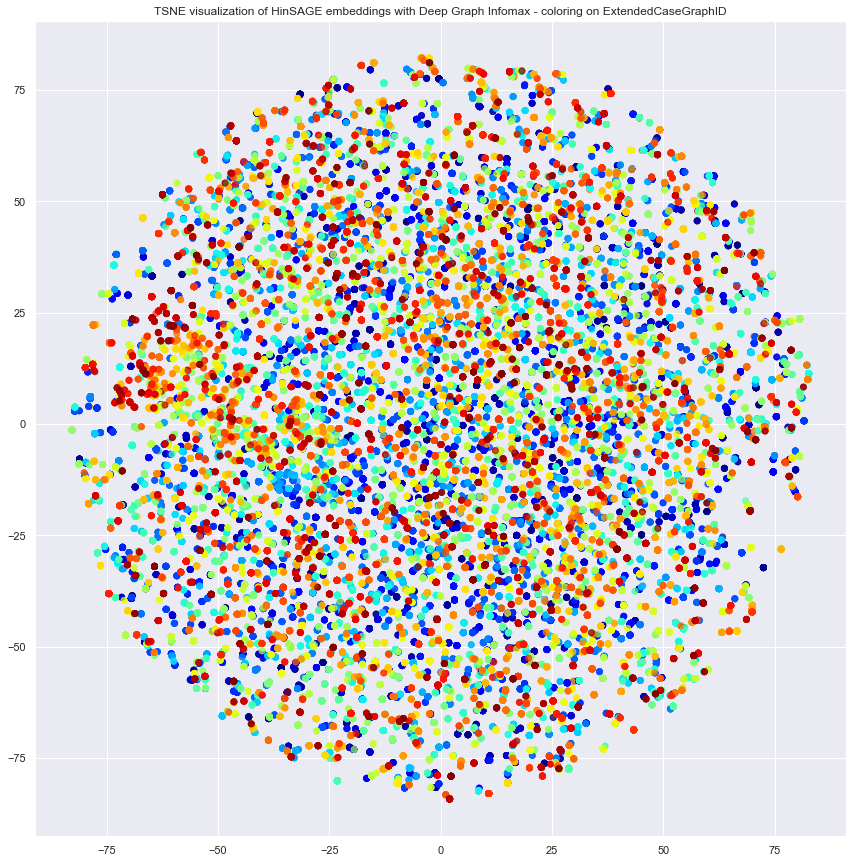

In [250]:
# visualize resampled fraudolent train set embeddings with tsne

train_set_res_2d = pd.DataFrame(
    TSNE(n_components=2).fit_transform(train_set_res),
    index=train_ext_labels_res
)

label_map = {l: i*10 for i, l in enumerate(np.unique(train_ext_labels_res), start=10)}
node_colours = [label_map[target] if pd.notna(target) else 0 for target in train_ext_labels_res]

alpha = 0.7
fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(
    train_set_res_2d[0],
    train_set_res_2d[1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal")
plt.title("TSNE visualization of HinSAGE embeddings with Deep Graph Infomax - coloring on ExtendedCaseGraphID")
plt.show()

In [246]:
pd.DataFrame(train_ext_labels_res).value_counts()

4000.0    24
1230.0    24
1200.0    24
1202.0    24
1203.0    24
          ..
2544.0    24
2545.0    24
2546.0    24
2548.0    24
1.0       24
Length: 2165, dtype: int64

In [213]:
classifier = LogisticRegression(
    verbose=0,
    solver='lbfgs',
)

In [240]:
classifier.fit(
    X=train_set_res,
    y=train_ext_labels_res,
)

LogisticRegression()

In [230]:
cv_pred = classifier.predict(cv_set)
f1_avg = f1_score(cv_ext_labels, cv_pred, average='micro')
acc = (cv_pred == cv_ext_labels).mean()

print(f"f1: {f1_avg:.3f} - acc: {acc:.3f}")

f1: 0.000 - acc: 0.000


In [231]:
# predictions
pd.DataFrame(cv_pred).value_counts().to_frame()

,0
0,
2284.0,63
2056.0,37
985.0,33
2329.0,31
3341.0,28
...,...
2824.0,1
1284.0,1
2826.0,1


In [236]:
# labels
pd.DataFrame(cv_ext_labels).value_counts().to_frame()

,0
0,
2449.0,12
2424.0,12
2896.0,10
3794.0,10
651.0,9
...,...
2120.0,1
2112.0,1
2107.0,1


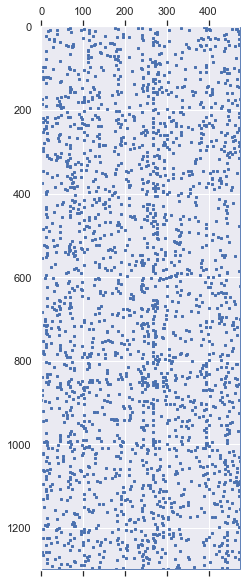

In [232]:
confusion_matrix = pd.crosstab(
    cv_ext_labels,
    cv_pred,
    rownames=['True'],
    colnames=['Predicted'],
    margins=True
)

sns.set(rc={'figure.figsize':(6, 10)})
plt.spy(confusion_matrix, precision = 0.1, markersize = 2)